In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
from PIL import Image

path = 'drive/MyDrive/mushroom_dataset'

In [ ]:
# Split the dataset into training and test sets and preprocesses the data to be the same dimensions.
# Load the training set with the following parameters:
# path: location of the dataset
# labels: inferred labels for the dataset
# label_mode: "categorical" to use categorical encoding for labels
# color_mode: "rgb" to use RGB color space
# batch_size: 32, the number of samples in each batch
# image_size: (100,100) to resize each image to 100x100 pixels
# seed: 1234, a random seed for reproducibility
# subset: "training" to select the training set
# validation_split: 0.2, the fraction of the training set to use for validation

training_iterator = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  batch_size = 32,
  image_size = (100,100),
  seed = 1234,
  subset = "training",
  validation_split = 0.2
)

testing_iterator = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  batch_size = 32,
  image_size = (100,100),
  seed = 1234,
  subset = "validation",
  validation_split = 0.2
)

# Print the training and testing sets to check the data was loaded correctly
print(training_iterator)
print(testing_iterator)

# Print the amount of batches in the training set
print("\nNumber of batches in training set: ", len(training_iterator))

Found 8781 files belonging to 4 classes.
Using 7025 files for training.
Found 8781 files belonging to 4 classes.
Using 1756 files for validation.
<BatchDataset shapes: ((None, 100, 100, 3), (None, 4)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 100, 100, 3), (None, 4)), types: (tf.float32, tf.float32)>
Number of images in training set:  220


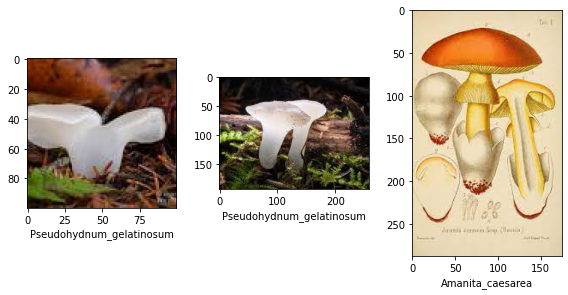

In [ ]:
# Load the images path for visualizing some samples of the data
edible_path = 'drive/MyDrive/mushroom_dataset/edible'
class_names = os.listdir(edible_path)
num_class = len(class_names)
image_files = [[os.path.join(edible_path, class_name, x) 
               for x in os.listdir(os.path.join(edible_path, class_name))] 
               for class_name in class_names]

# Load the images into a file list
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)

# Show the images using plots
plt.subplots(3,3, figsize=(8,8))
for i,k in enumerate(np.random.randint(num_total, size=3)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    plt.subplot(1,3, i+1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [ ]:
# Count the amount of batches in each class
# As you can see, there's quite an imbalance between the different classes which will be solutioned with the next cell
class_names = training_iterator.class_names
class_counts = {class_name: 0 for class_name in class_names}
for example in training_iterator:
  label = int(example[1].numpy().argmax())
  class_name = class_names[label]
  class_counts[class_name] += 1

for class_name, count in class_counts.items():
  print(f"Number of {class_name} images: {count}")

Number of conditionally_edible images: 14
Number of deadly images: 33
Number of edible images: 69
Number of poisonous images: 104


In [ ]:
def get_class_weights(dataset):
    # Create an empty list to store the labels
    labels = []

    # Iterate through the dataset to extract the labels of each image
    for image, label in dataset:
        # Append the argmax of the label (converted to a list) to the labels list
        labels.extend(label.numpy().argmax(axis=1).tolist())
    # Get the number of unique labels in the dataset
    class_counts = len(np.unique(labels))
    # Calculate the frequency of each label in the dataset
    class_weights = 1.0 / np.bincount(labels)
    # Normalize the class weights to balance the importance of each class in the loss function
    class_weights = class_weights * class_counts / np.sum(class_weights)
    return class_weights

# Get the class names from the training dataset
class_names = training_iterator.class_names
# Calculate the class weights based on the frequency of each label in the training dataset
class_weights = get_class_weights(training_iterator)
# Convert the class weights to a dictionary, where the keys are the indices of the labels
class_weights = dict(enumerate(class_weights))

# Print the class names and class weights
print(class_names)
print(class_weights)

['conditionally_edible', 'deadly', 'edible', 'poisonous']
{0: 2.471566125114389, 1: 0.882142925331218, 2: 0.42470226247517207, 3: 0.22158868707922105}


In [ ]:
# Store the class weights into an array to not have to run the weight calculator again
class_weights_init=[2.471566125114389, 0.882142925331218, 0.42470226247517207, 0.22158868707922105]
# Convert the class weights into a dictionary for use in the model
class_weights=dict(enumerate(class_weights_init))

print(class_names)
print(class_weights)

['conditionally_edible', 'deadly', 'edible', 'poisonous']
{0: 2.471566125114389, 1: 0.882142925331218, 2: 0.42470226247517207, 3: 0.22158868707922105}


In [ ]:
# Running the code on GPU:0 to increase computation speed
with tf.device('/GPU:0'):
  # Create the model
  model = tf.keras.Sequential()

  # Adding Conv2D layer with 180 filters, kernel size of (3, 3), activation as ReLU and input shape of (100, 100, 3)
  model.add(layers.Conv2D(180, (3, 3), activation='relu', input_shape=(100, 100, 3)))
  # Adding MaxPooling2D layer with pool size of (2, 2)
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(190, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(200, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(210, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  # Flattening the output of convolutional layers
  model.add(layers.Flatten())

  # Adding Dense layer with 210 neurons and activation as ReLU
  model.add(layers.Dense(210, activation='relu'))
  # Adding output layer with 4 neurons and activation as Softmax
  model.add(layers.Dense(4, activation='softmax'))

  # Compile the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Fitting the model on the training dataset with validation data as the testing dataset for 60 epochs and using class_weights to handle class imbalance
  history = model.fit(training_iterator, validation_data = testing_iterator, epochs=60, class_weight=class_weights)

Epoch 1/60
108/220 [=============>................] - ETA: 3s - loss: 1.5882 - accuracy: 0.1976

Cleanup called...


220/220 [==============================] - 85s 40ms/step - loss: 1.1084 - accuracy: 0.2335 - val_loss: 1.3608 - val_accuracy: 0.2819
Epoch 2/60
108/220 [=============>................] - ETA: 3s - loss: 0.6687 - accuracy: 0.2422

Cleanup called...


220/220 [==============================] - 8s 37ms/step - loss: 0.6558 - accuracy: 0.2495 - val_loss: 1.3490 - val_accuracy: 0.3645
Epoch 3/60
109/220 [=============>................] - ETA: 3s - loss: 0.6722 - accuracy: 0.2185

Cleanup called...


220/220 [==============================] - 8s 35ms/step - loss: 0.6524 - accuracy: 0.2559 - val_loss: 1.3706 - val_accuracy: 0.2796
Epoch 4/60
107/220 [=============>................] - ETA: 3s - loss: 0.6472 - accuracy: 0.2354

Cleanup called...


220/220 [==============================] - 8s 35ms/step - loss: 0.6408 - accuracy: 0.2629 - val_loss: 1.3385 - val_accuracy: 0.2984
Epoch 5/60
108/220 [=============>................] - ETA: 3s - loss: 0.6458 - accuracy: 0.2428

Cleanup called...


220/220 [==============================] - 8s 36ms/step - loss: 0.6376 - accuracy: 0.2584 - val_loss: 1.4031 - val_accuracy: 0.1948
Epoch 6/60
109/220 [=============>................] - ETA: 3s - loss: 0.6480 - accuracy: 0.2618

Cleanup called...


220/220 [==============================] - 7s 33ms/step - loss: 0.6350 - accuracy: 0.2727 - val_loss: 1.3246 - val_accuracy: 0.3200
Epoch 7/60
109/220 [=============>................] - ETA: 3s - loss: 0.6377 - accuracy: 0.3010

Cleanup called...


220/220 [==============================] - 8s 36ms/step - loss: 0.6197 - accuracy: 0.3080 - val_loss: 1.2473 - val_accuracy: 0.4539
Epoch 8/60
108/220 [=============>................] - ETA: 3s - loss: 0.6142 - accuracy: 0.3166

Cleanup called...


220/220 [==============================] - 8s 38ms/step - loss: 0.6047 - accuracy: 0.3216 - val_loss: 1.3104 - val_accuracy: 0.3491
Epoch 9/60
108/220 [=============>................] - ETA: 3s - loss: 0.6002 - accuracy: 0.3377

Cleanup called...


220/220 [==============================] - 8s 35ms/step - loss: 0.5871 - accuracy: 0.3446 - val_loss: 1.2820 - val_accuracy: 0.3650
Epoch 10/60
109/220 [=============>................] - ETA: 3s - loss: 0.5936 - accuracy: 0.3357

Cleanup called...


220/220 [==============================] - 8s 37ms/step - loss: 0.5823 - accuracy: 0.3468 - val_loss: 1.3486 - val_accuracy: 0.3297
Epoch 11/60
107/220 [=============>................] - ETA: 3s - loss: 0.5717 - accuracy: 0.3662

Cleanup called...


220/220 [==============================] - 8s 35ms/step - loss: 0.5667 - accuracy: 0.3656 - val_loss: 1.3335 - val_accuracy: 0.3280
Epoch 12/60
108/220 [=============>................] - ETA: 3s - loss: 0.5521 - accuracy: 0.3770

Cleanup called...


220/220 [==============================] - 8s 36ms/step - loss: 0.5514 - accuracy: 0.3721 - val_loss: 1.3364 - val_accuracy: 0.2956
Epoch 13/60
110/220 [==============>...............] - ETA: 3s - loss: 0.5450 - accuracy: 0.3741

Cleanup called...


220/220 [==============================] - 8s 35ms/step - loss: 0.5268 - accuracy: 0.3920 - val_loss: 1.3625 - val_accuracy: 0.3388
Epoch 14/60
108/220 [=============>................] - ETA: 3s - loss: 0.5011 - accuracy: 0.4149

Cleanup called...


220/220 [==============================] - 8s 38ms/step - loss: 0.4815 - accuracy: 0.4393 - val_loss: 1.4138 - val_accuracy: 0.3440
Epoch 15/60
109/220 [=============>................] - ETA: 3s - loss: 0.4483 - accuracy: 0.4719

Cleanup called...


220/220 [==============================] - 8s 33ms/step - loss: 0.4355 - accuracy: 0.4871 - val_loss: 1.4282 - val_accuracy: 0.3548
Epoch 16/60
109/220 [=============>................] - ETA: 3s - loss: 0.4146 - accuracy: 0.5186

Cleanup called...


220/220 [==============================] - 8s 34ms/step - loss: 0.3943 - accuracy: 0.5330 - val_loss: 1.3783 - val_accuracy: 0.3890
Epoch 17/60
109/220 [=============>................] - ETA: 3s - loss: 0.3877 - accuracy: 0.5611

Cleanup called...


220/220 [==============================] - 8s 34ms/step - loss: 0.3651 - accuracy: 0.5735 - val_loss: 1.6596 - val_accuracy: 0.3798
Epoch 18/60
109/220 [=============>................] - ETA: 3s - loss: 0.3632 - accuracy: 0.5834

Cleanup called...


220/220 [==============================] - 8s 38ms/step - loss: 0.3332 - accuracy: 0.6068 - val_loss: 1.7357 - val_accuracy: 0.4203
Epoch 19/60
109/220 [=============>................] - ETA: 3s - loss: 0.3165 - accuracy: 0.6399

Cleanup called...


220/220 [==============================] - 8s 35ms/step - loss: 0.2914 - accuracy: 0.6602 - val_loss: 1.7842 - val_accuracy: 0.4505
Epoch 20/60
108/220 [=============>................] - ETA: 3s - loss: 0.2950 - accuracy: 0.6562

Cleanup called...


220/220 [==============================] - 8s 35ms/step - loss: 0.2848 - accuracy: 0.6699 - val_loss: 1.7935 - val_accuracy: 0.4339
Epoch 21/60
109/220 [=============>................] - ETA: 3s - loss: 0.2838 - accuracy: 0.6872

Cleanup called...


220/220 [==============================] - 8s 37ms/step - loss: 0.2732 - accuracy: 0.6934 - val_loss: 1.7181 - val_accuracy: 0.4089
Epoch 22/60
109/220 [=============>................] - ETA: 3s - loss: 0.3270 - accuracy: 0.6577

Cleanup called...


220/220 [==============================] - 7s 33ms/step - loss: 0.2890 - accuracy: 0.6800 - val_loss: 1.7134 - val_accuracy: 0.4493
Epoch 23/60
110/220 [==============>...............] - ETA: 3s - loss: 0.2268 - accuracy: 0.7207

Cleanup called...


220/220 [==============================] - 8s 34ms/step - loss: 0.2162 - accuracy: 0.7392 - val_loss: 2.1024 - val_accuracy: 0.4556
Epoch 24/60
106/220 [=============>................] - ETA: 3s - loss: 0.1863 - accuracy: 0.7762

Cleanup called...


220/220 [==============================] - 8s 35ms/step - loss: 0.1867 - accuracy: 0.7851 - val_loss: 2.2783 - val_accuracy: 0.4254
Epoch 25/60
107/220 [=============>................] - ETA: 3s - loss: 0.1963 - accuracy: 0.7725

Cleanup called...


220/220 [==============================] - 8s 34ms/step - loss: 0.1868 - accuracy: 0.7832 - val_loss: 2.2118 - val_accuracy: 0.4482
Epoch 26/60
108/220 [=============>................] - ETA: 3s - loss: 0.2156 - accuracy: 0.7682

Cleanup called...


220/220 [==============================] - 8s 35ms/step - loss: 0.2219 - accuracy: 0.7673 - val_loss: 2.6581 - val_accuracy: 0.4140
Epoch 27/60
108/220 [=============>................] - ETA: 3s - loss: 0.3194 - accuracy: 0.6982

Cleanup called...


220/220 [==============================] - 8s 36ms/step - loss: 0.2484 - accuracy: 0.7498 - val_loss: 2.1627 - val_accuracy: 0.4465
Epoch 28/60
109/220 [=============>................] - ETA: 3s - loss: 0.1549 - accuracy: 0.8191

Cleanup called...


220/220 [==============================] - 8s 36ms/step - loss: 0.1609 - accuracy: 0.8179 - val_loss: 2.3828 - val_accuracy: 0.4801
Epoch 29/60
109/220 [=============>................] - ETA: 3s - loss: 0.2086 - accuracy: 0.7973

Cleanup called...


220/220 [==============================] - 8s 35ms/step - loss: 0.1858 - accuracy: 0.8117 - val_loss: 2.4121 - val_accuracy: 0.4146
Epoch 30/60
109/220 [=============>................] - ETA: 3s - loss: 0.1385 - accuracy: 0.8486

Cleanup called...


220/220 [==============================] - 8s 34ms/step - loss: 0.1430 - accuracy: 0.8428 - val_loss: 2.5388 - val_accuracy: 0.4647
Epoch 31/60
109/220 [=============>................] - ETA: 3s - loss: 0.1438 - accuracy: 0.8509

Cleanup called...


220/220 [==============================] - 8s 37ms/step - loss: 0.1344 - accuracy: 0.8572 - val_loss: 2.5356 - val_accuracy: 0.4755
Epoch 32/60
108/220 [=============>................] - ETA: 3s - loss: 0.1201 - accuracy: 0.8727

Cleanup called...


220/220 [==============================] - 8s 35ms/step - loss: 0.1192 - accuracy: 0.8716 - val_loss: 3.0204 - val_accuracy: 0.4465
Epoch 33/60
109/220 [=============>................] - ETA: 3s - loss: 0.1535 - accuracy: 0.8518

Cleanup called...


220/220 [==============================] - 8s 35ms/step - loss: 0.1650 - accuracy: 0.8336 - val_loss: 2.4170 - val_accuracy: 0.4351
Epoch 34/60
108/220 [=============>................] - ETA: 3s - loss: 0.1154 - accuracy: 0.8776

Cleanup called...


220/220 [==============================] - 8s 35ms/step - loss: 0.1230 - accuracy: 0.8780 - val_loss: 2.5355 - val_accuracy: 0.4721
Epoch 35/60
109/220 [=============>................] - ETA: 3s - loss: 0.1169 - accuracy: 0.8764

Cleanup called...


220/220 [==============================] - 7s 33ms/step - loss: 0.1187 - accuracy: 0.8789 - val_loss: 2.5660 - val_accuracy: 0.4749
Epoch 36/60
109/220 [=============>................] - ETA: 3s - loss: 0.1133 - accuracy: 0.8868

Cleanup called...


220/220 [==============================] - 8s 35ms/step - loss: 0.1088 - accuracy: 0.8867 - val_loss: 2.7003 - val_accuracy: 0.4932
Epoch 37/60
108/220 [=============>................] - ETA: 3s - loss: 0.1018 - accuracy: 0.8987

Cleanup called...


220/220 [==============================] - 8s 34ms/step - loss: 0.0978 - accuracy: 0.8985 - val_loss: 2.8969 - val_accuracy: 0.4630
Epoch 38/60
108/220 [=============>................] - ETA: 3s - loss: 0.1038 - accuracy: 0.8953

Cleanup called...


220/220 [==============================] - 9s 40ms/step - loss: 0.1048 - accuracy: 0.8988 - val_loss: 2.5992 - val_accuracy: 0.4903
Epoch 39/60
108/220 [=============>................] - ETA: 3s - loss: 0.0830 - accuracy: 0.9245

Cleanup called...


220/220 [==============================] - 8s 36ms/step - loss: 0.0942 - accuracy: 0.9107 - val_loss: 2.7862 - val_accuracy: 0.4892
Epoch 40/60
107/220 [=============>................] - ETA: 3s - loss: 0.0968 - accuracy: 0.9083

Cleanup called...


220/220 [==============================] - 8s 36ms/step - loss: 0.1040 - accuracy: 0.8977 - val_loss: 2.5520 - val_accuracy: 0.4846
Epoch 41/60
107/220 [=============>................] - ETA: 3s - loss: 0.0814 - accuracy: 0.9220

Cleanup called...


220/220 [==============================] - 8s 36ms/step - loss: 0.0903 - accuracy: 0.9154 - val_loss: 2.8152 - val_accuracy: 0.4795
Epoch 42/60
110/220 [==============>...............] - ETA: 2s - loss: 0.0907 - accuracy: 0.9102

Cleanup called...


220/220 [==============================] - 8s 36ms/step - loss: 0.0966 - accuracy: 0.9079 - val_loss: 2.8044 - val_accuracy: 0.4858
Epoch 43/60
109/220 [=============>................] - ETA: 3s - loss: 0.1493 - accuracy: 0.8741

Cleanup called...


220/220 [==============================] - 8s 36ms/step - loss: 0.1362 - accuracy: 0.8773 - val_loss: 2.8268 - val_accuracy: 0.4806
Epoch 44/60
108/220 [=============>................] - ETA: 3s - loss: 0.0977 - accuracy: 0.9129

Cleanup called...


220/220 [==============================] - 8s 36ms/step - loss: 0.0992 - accuracy: 0.9082 - val_loss: 2.5558 - val_accuracy: 0.4710
Epoch 45/60
108/220 [=============>................] - ETA: 3s - loss: 0.0693 - accuracy: 0.9320

Cleanup called...


220/220 [==============================] - 8s 36ms/step - loss: 0.0806 - accuracy: 0.9241 - val_loss: 2.6479 - val_accuracy: 0.5011
Epoch 46/60
109/220 [=============>................] - ETA: 3s - loss: 0.0689 - accuracy: 0.9401

Cleanup called...


220/220 [==============================] - 9s 42ms/step - loss: 0.0834 - accuracy: 0.9246 - val_loss: 3.0498 - val_accuracy: 0.4926
Epoch 47/60
108/220 [=============>................] - ETA: 3s - loss: 0.0712 - accuracy: 0.9366

Cleanup called...


220/220 [==============================] - 8s 34ms/step - loss: 0.0797 - accuracy: 0.9327 - val_loss: 2.8216 - val_accuracy: 0.5074
Epoch 48/60
109/220 [=============>................] - ETA: 3s - loss: 0.0874 - accuracy: 0.9151

Cleanup called...


220/220 [==============================] - 8s 36ms/step - loss: 0.0871 - accuracy: 0.9152 - val_loss: 2.9118 - val_accuracy: 0.4852
Epoch 49/60
107/220 [=============>................] - ETA: 3s - loss: 0.0731 - accuracy: 0.9334

Cleanup called...


220/220 [==============================] - 9s 38ms/step - loss: 0.0734 - accuracy: 0.9312 - val_loss: 3.2338 - val_accuracy: 0.4778
Epoch 50/60
109/220 [=============>................] - ETA: 3s - loss: 0.0791 - accuracy: 0.9389

Cleanup called...


220/220 [==============================] - 8s 34ms/step - loss: 0.0888 - accuracy: 0.9251 - val_loss: 2.8905 - val_accuracy: 0.4772
Epoch 51/60
108/220 [=============>................] - ETA: 2s - loss: 0.0647 - accuracy: 0.9401

Cleanup called...


220/220 [==============================] - 8s 34ms/step - loss: 0.0660 - accuracy: 0.9372 - val_loss: 2.9344 - val_accuracy: 0.4880
Epoch 52/60
108/220 [=============>................] - ETA: 3s - loss: 0.0569 - accuracy: 0.9499

Cleanup called...


220/220 [==============================] - 8s 34ms/step - loss: 0.0613 - accuracy: 0.9448 - val_loss: 3.2960 - val_accuracy: 0.5006
Epoch 53/60
108/220 [=============>................] - ETA: 3s - loss: 0.0595 - accuracy: 0.9430

Cleanup called...


220/220 [==============================] - 8s 37ms/step - loss: 0.0834 - accuracy: 0.9250 - val_loss: 3.0816 - val_accuracy: 0.4470
Epoch 54/60
106/220 [=============>................] - ETA: 3s - loss: 0.1521 - accuracy: 0.8712

Cleanup called...


220/220 [==============================] - 8s 36ms/step - loss: 0.1261 - accuracy: 0.8895 - val_loss: 4.2436 - val_accuracy: 0.4470
Epoch 55/60
109/220 [=============>................] - ETA: 3s - loss: 0.1143 - accuracy: 0.9080

Cleanup called...


220/220 [==============================] - 8s 36ms/step - loss: 0.1038 - accuracy: 0.9105 - val_loss: 3.0650 - val_accuracy: 0.5006
Epoch 56/60
108/220 [=============>................] - ETA: 2s - loss: 0.0989 - accuracy: 0.9210

Cleanup called...


220/220 [==============================] - 7s 33ms/step - loss: 0.1045 - accuracy: 0.9096 - val_loss: 2.6654 - val_accuracy: 0.4687
Epoch 57/60
108/220 [=============>................] - ETA: 3s - loss: 0.0923 - accuracy: 0.9210

Cleanup called...


220/220 [==============================] - 8s 34ms/step - loss: 0.0817 - accuracy: 0.9230 - val_loss: 3.2270 - val_accuracy: 0.4875
Epoch 58/60
109/220 [=============>................] - ETA: 3s - loss: 0.0586 - accuracy: 0.9441

Cleanup called...


220/220 [==============================] - 8s 34ms/step - loss: 0.0567 - accuracy: 0.9443 - val_loss: 3.5209 - val_accuracy: 0.5051
Epoch 59/60
108/220 [=============>................] - ETA: 3s - loss: 0.0609 - accuracy: 0.9416

Cleanup called...


220/220 [==============================] - 8s 34ms/step - loss: 0.0660 - accuracy: 0.9431 - val_loss: 3.3904 - val_accuracy: 0.5091
Epoch 60/60
108/220 [=============>................] - ETA: 3s - loss: 0.0691 - accuracy: 0.9410

Cleanup called...


220/220 [==============================] - 8s 36ms/step - loss: 0.0799 - accuracy: 0.9322 - val_loss: 3.2268 - val_accuracy: 0.5006


In [ ]:
# Save the model
model.save('MUSHROOMS.h5')

In [ ]:
# Evaluate the training dataset
model.evaluate(training_iterator)

111/220 [==============>...............] - ETA: 2s - loss: 0.6576 - accuracy: 0.8187

Cleanup called...


220/220 [==============================] - 5s 24ms/step - loss: 0.4960 - accuracy: 0.8594


[0.49599236249923706, 0.8593594431877136]

In [ ]:
# Evaluate the testing dataset
model.evaluate(testing_iterator)

55/55 [==============================] - 1s 22ms/step - loss: 3.2268 - accuracy: 0.5006


[3.2267978191375732, 0.5005694627761841]

In [ ]:
# Load the images for prediction
from PIL import Image

edible = Image.open("drive/MyDrive/mushroom_predict/edible/edible1.png")
C_edible = Image.open("drive/MyDrive/mushroom_predict/conditionally_edible/c_edible1.png")
poisonous = Image.open("drive/MyDrive/mushroom_predict/poisonous/poisonous1.png")
deadly = Image.open("drive/MyDrive/mushroom_predict/deadly/deadly1.png")

# Process the images to be suitable for prediction
edible_processed = np.array(edible.resize((100,100))) / 255.0
edible_processed = np.expand_dims(edible_processed, axis=0)

C_edible_processed = np.array(C_edible.resize((100,100))) / 255.0
C_edible_processed = np.expand_dims(C_edible_processed, axis=0)

poisonous_processed = np.array(poisonous.resize((100,100))) / 255.0
poisonous_processed = np.expand_dims(poisonous_processed, axis=0)

deadly_processed = np.array(deadly.resize((100,100))) / 255.0
deadly_processed = np.expand_dims(deadly_processed, axis=0)

In [ ]:
# Predict invidiual images
# From the output of the prediction of the individual images, the model isn't able to properly predict the right class with the results skewing more towards poisonous
model = tf.keras.models.load_model('MUSHROOMS.h5')

print("Corresponding classes:")
print(class_names, '\n')

# Edible input
model_result = model.predict(edible_processed)
# Get the index of the predicted class
model_result_index = np.argmax(model_result)
# Get the label of the predicted class
model_result_label = class_names[model_result_index]
# Print the prediction results
print('Input: Edible --- PREDICTION: ', model_result_label, '\n', model_result, '\n')

# Conditionally Edible input
model_result = model.predict(C_edible_processed)
model_result_index = np.argmax(model_result)
model_result_label = class_names[model_result_index]
print('Input: Conditionally Edible --- PREDICTION: ', model_result_label, '\n', model_result, '\n')

# Poisonous input
model_result = model.predict(poisonous_processed)
model_result_index = np.argmax(model_result)
model_result_label = class_names[model_result_index]
print('Input: Poisonous --- PREDICTION: ', model_result_label, '\n', model_result, '\n')

# Deadly input
model_result = model.predict(deadly_processed)
model_result_index = np.argmax(model_result)
model_result_label = class_names[model_result_index]
print('Input: Deadly --- PREDICTION: ', model_result_label, '\n', model_result, '\n')
print(model_result)

['conditionally_edible', 'deadly', 'edible', 'poisonous']
Input: Edible --- PREDICTION:  poisonous 


Input: Conditionally Edible --- PREDICTION:  poisonous 


Input: Poisonous --- PREDICTION:  poisonous 


Input: Deadly --- PREDICTION:  poisonous 


[[0.13301224 0.18234347 0.18564777 0.4989965 ]]


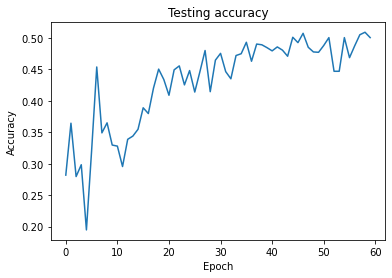

In [ ]:
# Plot the training accuracy
# As seen in this plot, the accuracy plateaus at around epoch 30 on 45%, eventually reaching 50%
plt.plot(history.history['val_accuracy'])
plt.title('Testing accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

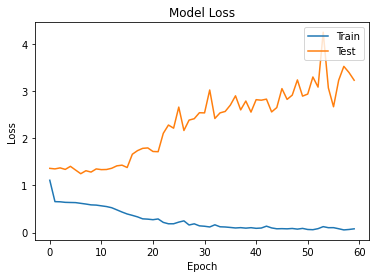

In [ ]:
# Plotting the loss
# The loss continually gets higher per epoch for the test set which indicates inaccurate results from the model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()